In [1]:
import pandas as pd
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import sys
!pip install gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!pip install textstat
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import confusion_matrix
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/martyna6525/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/martyna6525/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
dataset = pd.read_csv('founta_dataset.csv', sep='\\t', header=None)
dataset.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0,1,2
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam,4
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4
2,It is time to draw close to Him &#128591;&#127...,normal,4
3,if you notice me start to act different or dis...,normal,5
4,"Forget unfollowers, I believe in growing. 7 ne...",normal,3


In [3]:
dataset.index.name = 'ID'
dataset.columns = ['text', 'label', 'votes']
dataset.head()

,text,label,votes
ID,,,
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam,4
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4
2,It is time to draw close to Him &#128591;&#127...,normal,4
3,if you notice me start to act different or dis...,normal,5
4,"Forget unfollowers, I believe in growing. 7 ne...",normal,3


In [4]:
text = dataset.text

In [5]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(text):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    text_space = text.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    text_name = text_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = text.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = text.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtext=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtext=newtext.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtext=newtext.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    text_lower = newtext.str.lower()
    
    # tokenizing
    tokenized_text = text_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_text=  tokenized_text.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the text
    tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_text)):
        tokenized_text[i] = ' '.join(tokenized_text[i])
        text_p= tokenized_text
    
    return text_p

processed_text = preprocess(text)   

dataset['processed_text'] = processed_text
print(dataset[["text","processed_text"]].head(10))

                                                 text  \
ID                                                      
0   Beats by Dr. Dre urBeats Wired In-Ear Headphon...   
1   RT @Papapishu: Man it would fucking rule if we...   
2   It is time to draw close to Him &#128591;&#127...   
3   if you notice me start to act different or dis...   
4   Forget unfollowers, I believe in growing. 7 ne...   
5   RT @Vitiligoprince: Hate Being sexually Frustr...   
6   Topped the group in TGP Disc Jam Season 2! Ont...   
7   That daily baby aspirin for your #heart just m...   
8   I liked a @YouTube video from @mattshea https:...   
9   RT @LestuhGang_: If your fucking up &amp; your...   

                                       processed_text  
ID                                                     
0          beat dr dre urbeat wire ear headphon white  
1   papapishu man would fuck rule parti perpetu wa...  
2              time draw close father draw near alway  
3   notic start act differ distant 

In [6]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_text'] )
tfidf

<99996x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 863273 stored elements in Compressed Sparse Row format>

In [7]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['label']

In [9]:
sentiment_analyzer = VS()
def count_tags(text_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(text):   
    sentiment = sentiment_analyzer.polarity_scores(text)    
    twitter_objs = count_tags(text)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pd.DataFrame(features)
    return features

def sentiment_analysis_array(texts):
    features=[]
    for t in texts:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(text)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.000,1.000,0.0000,2.0,0.0,0.0
1,0.116,0.143,0.741,0.1280,0.0,1.0,0.0
2,0.000,0.000,1.000,0.0000,1.0,0.0,2.0
3,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
4,0.138,0.107,0.755,-0.1260,1.0,0.0,0.0
...,...,...,...,...,...,...,...
99991,0.000,0.000,1.000,0.0000,1.0,1.0,0.0
99992,0.000,0.000,1.000,0.0000,2.0,0.0,3.0
99993,0.405,0.000,0.595,-0.9430,0.0,1.0,4.0
99994,0.000,0.000,1.000,0.0000,2.0,0.0,3.0


In [10]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(99996, 10007)

In [12]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_text"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_text"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
ID,,,,,
0,-0.007247,0.210878,0.245596,0.068894,-0.337243
1,0.102374,0.277735,-0.035617,-0.053147,-0.115178
2,0.119710,0.002761,-0.013994,-0.057815,0.006945
3,0.014502,-0.120260,0.227665,-0.037897,0.122347
4,-0.227692,-0.495088,0.224947,-0.215771,0.359873
...,...,...,...,...,...
99991,0.032149,0.181079,0.186056,0.001743,-0.141475
99992,-0.061045,0.227174,0.222410,0.184262,-0.097945
99993,0.227166,-0.055357,-0.050826,0.183443,0.145716


In [13]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(99996, 10012)

In [14]:
X = pd.DataFrame(modelling_features)
y = dataset['label']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

     abusive       0.87      0.90      0.88      5369
     hateful       0.67      0.25      0.36       966
      normal       0.81      0.92      0.86     10848
        spam       0.62      0.41      0.49      2817

    accuracy                           0.81     20000
   macro avg       0.74      0.62      0.65     20000
weighted avg       0.79      0.81      0.79     20000

Logistic Regression, Accuracy Score: 0.80795


In [15]:
X = pd.DataFrame(modelling_features)
y = dataset['label']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:", acc1)

              precision    recall  f1-score   support

     abusive       0.85      0.91      0.88      5369
     hateful       0.67      0.18      0.29       966
      normal       0.79      0.94      0.86     10848
        spam       0.66      0.23      0.34      2817

    accuracy                           0.80     20000
   macro avg       0.74      0.56      0.59     20000
weighted avg       0.78      0.80      0.76     20000

Random Forest, Accuracy Score: 0.7955


In [16]:
X = pd.DataFrame(modelling_features)
y = dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("Naive Bayes, Accuracy Score:", acc2)

              precision    recall  f1-score   support

     abusive       0.61      0.36      0.45      5369
     hateful       0.08      0.66      0.15       966
      normal       0.81      0.19      0.30     10848
        spam       0.29      0.67      0.40      2817

    accuracy                           0.33     20000
   macro avg       0.45      0.47      0.33     20000
weighted avg       0.65      0.33      0.35     20000

Naive Bayes, Accuracy Score: 0.32555


In [17]:
X = pd.DataFrame(modelling_features)
y = dataset['label']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support = LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3 = accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

     abusive       0.87      0.90      0.88      5369
     hateful       0.62      0.27      0.37       966
      normal       0.81      0.91      0.86     10848
        spam       0.59      0.41      0.49      2817

    accuracy                           0.80     20000
   macro avg       0.72      0.62      0.65     20000
weighted avg       0.79      0.80      0.79     20000

SVM, Accuracy Score: 0.8035


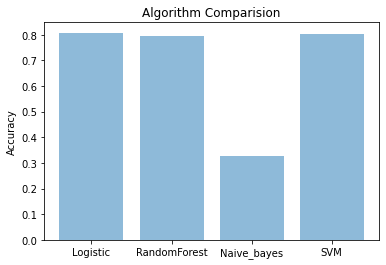

In [18]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align = 'center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()